In [1]:
import numpy as np
import pandas as pd
import random as rand
import seaborn as sns
import time
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jacob Turner\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Define functions to prep data.

In [2]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = rand.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
    return normalized_df

def unnormalize(df, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * df.std() + df.mean()
    else:
        # min max normalization
        unnormalized_df = (df * (df.max() - df.min())) + df.min()
    return unnormalized_df

# Decision Tree

In [3]:
class Decision_Tree:
    
    def __init__(self, x, y, 
                 num_features, 
                 min_leaf, 
                 max_depth):
        
        # init data
        self.x = x
        self.y = y
        self.num_rows = x.shape[0]
        
        # init hyperparameters
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        
        #
        self.num_features = num_features 
        self.val = np.mean(y.values[:])
        
        self.score = np.inf
        self.find_split()

        
    def std(self, count, ssum, squared_sum):
        return np.abs( (squared_sum / count) - (ssum / count)**2 )
    
    def find_split(self):
        
        for feature in self.num_features:
            self.check_split(feature)
        
        
        if self.score == np.inf or self.max_depth <= 0:
            return

        x = self.x.values[:, self.split_feature]

        left = np.nonzero(x <= self.split_val)[0]
        right = np.nonzero(x > self.split_val)[0]

        self.left_tree = Decision_Tree(self.x.iloc[left], self.y.iloc[left], self.num_features, self.min_leaf, self.max_depth - 1)
        self.right_tree = Decision_Tree(self.x.iloc[right], self.y.iloc[right], self.num_features, self.min_leaf, self.max_depth - 1)

    def check_split(self, feature):
        
        # sort data
        x = self.x.values[:, feature][np.argsort(self.x.values[:, feature])]
        y = self.y.values[:][np.argsort(self.x.values[:, feature])]
        
        # set counters
        left_count = 0
        left_sum = 0.0
        left_squared_sum = 0.0
        right_count = self.num_rows
        right_sum = np.sum(y)
        right_squared_sum = np.sum(y ** 2)
        
        # loop through data
        for i in range(0, self.num_rows - self.min_leaf):
            
            left_count += 1
            left_sum += y[i]
            left_squared_sum += y[i] ** 2
            
            right_count -= 1            
            right_sum -= y[i]
            right_squared_sum -= y[i] ** 2

            left_std = self.std(left_count, left_sum, left_squared_sum)
            right_std = self.std(right_count, right_sum, right_squared_sum)
            score = left_std * left_count + right_std * right_count

            if score < self.score:
                self.split_feature = feature
                self.score = score
                self.split_val = x[i]

    def predict_one(self, x):
        
        if self.score == np.inf or self.max_depth <= 0:
            return self.val

        if x[self.split_feature] <= self.split_val:
            return self.left_tree.predict_one(x)
        else:
            return self.right_tree.predict_one(x)
        
    def predict(self, x):
        
        vals = []
        for i in x.values:
            vals.append(self.predict_one(i))
        
        return np.array(vals)

    


# Random Forest 

In [4]:
class Random_Forest:
    
    def __init__(self, x_train, y_train, x_test, y_test, 
                 num_features = None, 
                 num_exemplars = None, 
                 n_estimators = 10,
                 min_leaf=1, 
                 max_depth=10):
        
        # init data
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test 
        
        # init hyperparameters
        self.n_estimators = int(n_estimators)
        self.max_depth = int(max_depth)
        self.min_leaf = int(min_leaf)
        
        if num_features == None:
            num_features = int(x_train.shape[1])
        if num_exemplars == None:
            num_exemplars = x_train.shape[0]
        
        self.num_features = np.random.randint(0, num_features, num_features)
        self.num_exemplars = num_exemplars
        
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])
    

    def fit(self, x, y):
        
        self.trees = [] # create tree for every estimator
        for n in range(self.n_estimators):
            rand_index = np.random.randint(y.shape[0], size=self.num_exemplars)
            self.trees.append(Decision_Tree(x.iloc[rand_index],
                                            y.iloc[rand_index],
                                            self.num_features, 
                                            self.min_leaf, 
                                            self.max_depth))
        
        
    def predict(self, x_test):
        
        y_trees = []
        
        # use every tree to make predictions
        for tree in self.trees:
            y_trees.append(tree.predict(x_test))
            
        # average every decision tree prediction for final y_pred
        y_pred = np.mean(y_trees, axis = 0)
        
        # calc mean square error
        MSE = self.MSE(y_pred, self.y_test)
        
        return y_pred, MSE


# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

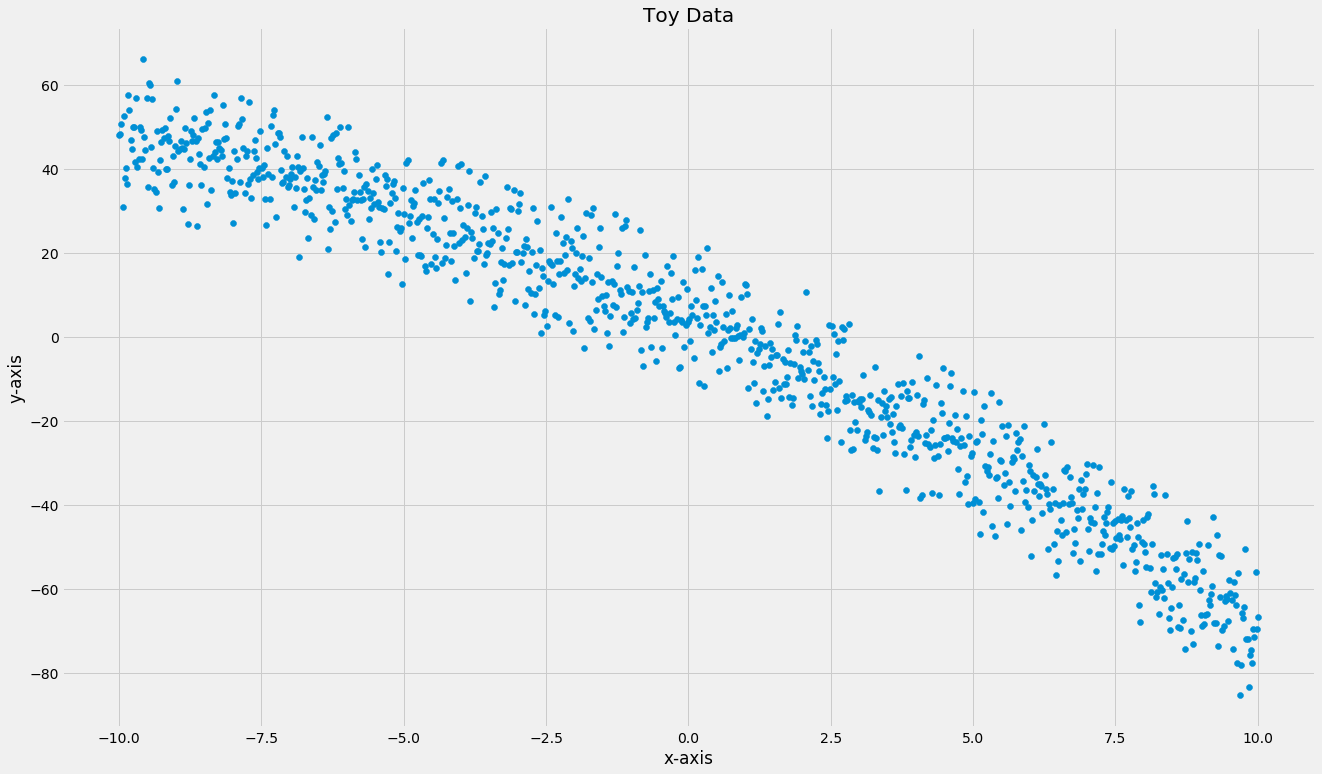

In [5]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 1000)
    
    y = []
    
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = random.uniform(rand.randint(-20,0),rand.randint(0,20))
        
        if linear:
            y.append(a*x[i] + b + noise)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            
    return x, y
    
x, y = f_toy(normal = False, linear = False)
plt.scatter(x,y)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [6]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
#train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]
x_valid, y_valid = validation.iloc[:,:-1], validation.iloc[:,-1]


In [7]:
RF = Random_Forest(x_train, y_train, x_test, y_test, 
                  n_estimators = 20, 
                  min_leaf = 1, 
                  max_depth = 10)

RF.fit(x_train, y_train)

y_pred, MSE = RF.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

df_pred = pd.DataFrame(np.array(x_test), columns = ['x_test'])
df_pred['y_test'] = np.array(y_test)
df_pred['y_pred'] = y_pred

C:\Users\Jacob Turner\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Jacob Turner\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Squared Error: 41.80266875863425


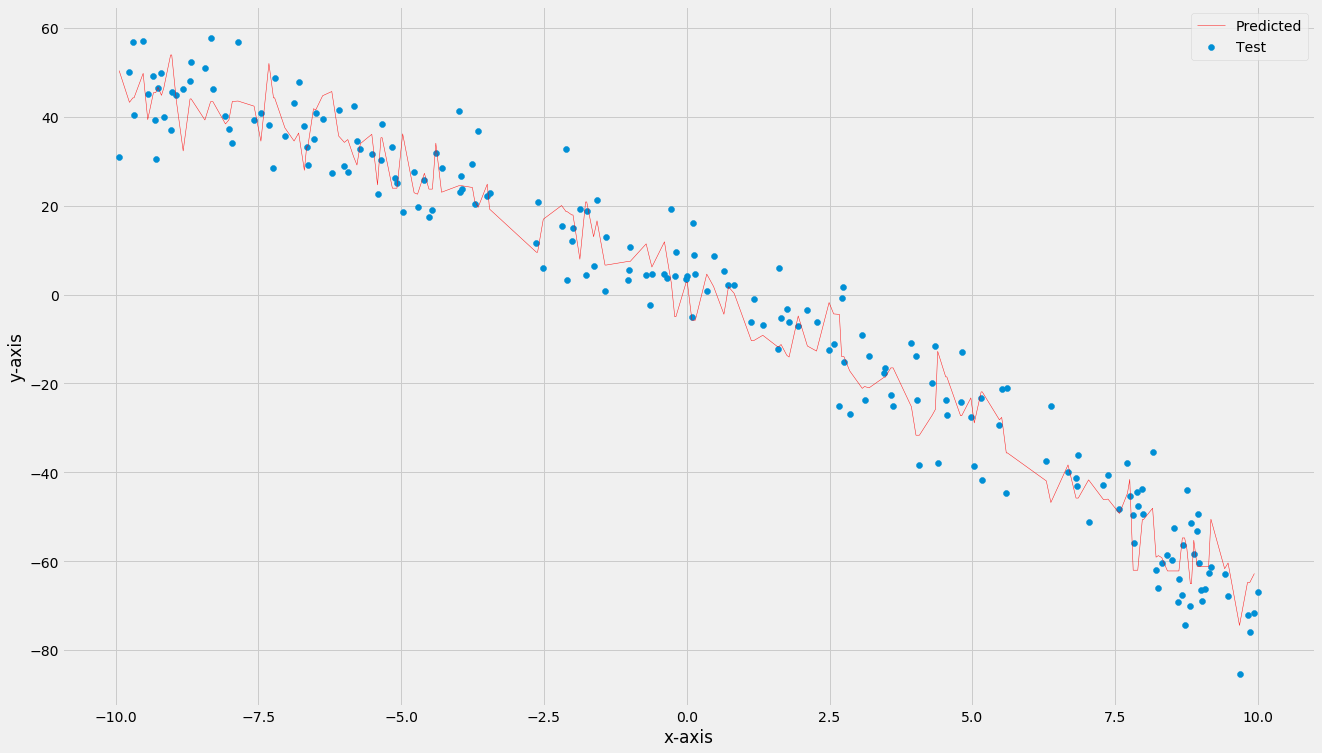

In [8]:
df_pred.sort_values(by = ['x_test'], inplace = True)

plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(df_pred['x_test'],df_pred['y_pred'], 
         c = 'red', 
         linewidth = 0.5,
            alpha = 0.9,
         label = 'Predicted')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

In [9]:
df = pd.read_csv('maize_major_yield/maize_major_yield.csv')
df = df.drop(['year'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
#train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
xTrain, yTrain = train.iloc[:,:-1], train.iloc[:,-1]
xTest, yTest = test.iloc[:,:-1], test.iloc[:,-1]
xValid, yValid = validation.iloc[:,:-1], validation.iloc[:,-1]

# normalize input data 
x_train, x_test, x_valid = normalize(xTrain), normalize(xTest), normalize(xValid)
y_train, y_test, y_valid = yTrain, yTest, yValid



In [10]:
RF = Random_Forest(x_train, y_train, x_test, y_test,
                  n_estimators = 5,
                  min_leaf = 1, 
                  max_depth = 10)

RF.fit(x_train, y_train) # fit random forest model to training data

# use model to make predictions from test data
y_pred, MSE = RF.predict(x_test) 
print("Mean Squared Error: {}".format(MSE))

C:\Users\Jacob Turner\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Jacob Turner\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Squared Error: 2.6324283939508173


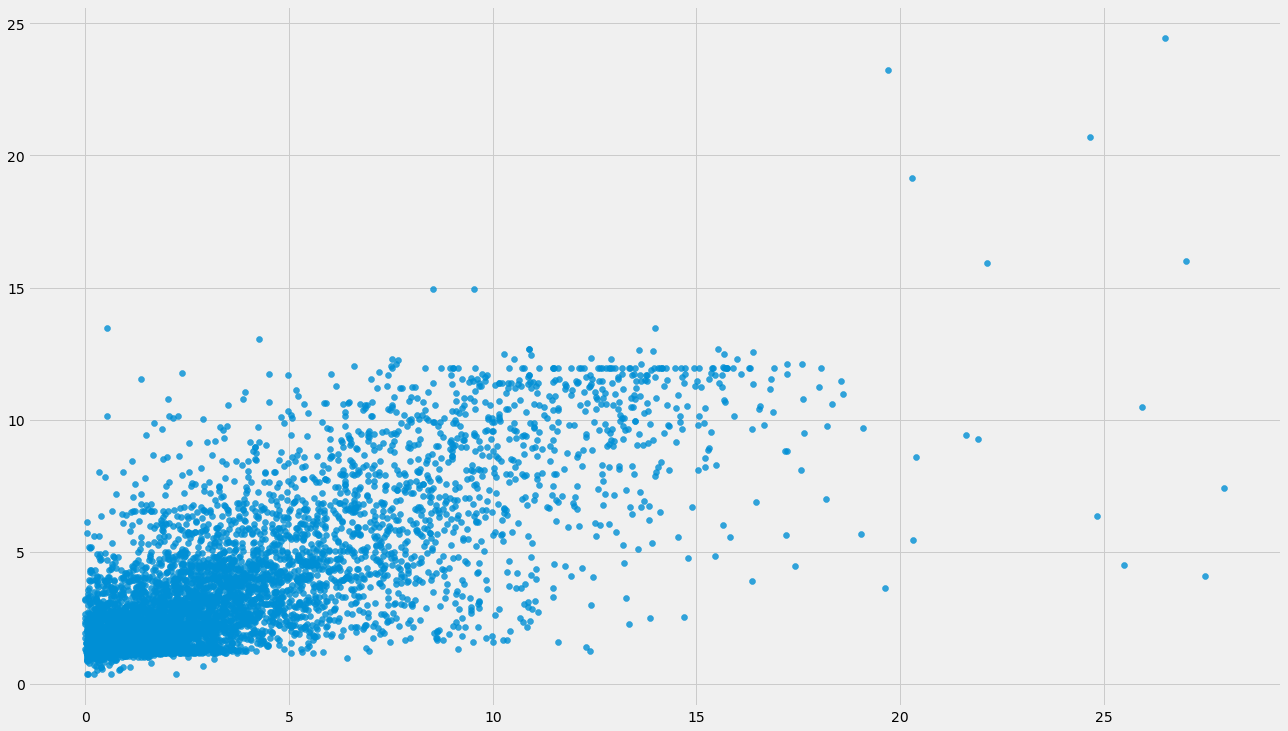

In [11]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_test'], df_pred['y_pred'], alpha = 0.8)

In [12]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.773202
y_pred,0.773202,1.000000


In [ ]:

estimators_space = np.linspace(1,30,30)
depth_space = np.linspace(10,30,5)

previous_MSE = np.inf

results = []
best_results = {}

iteration = 0
for estimators in estimators_space:
    for depth in depth_space:
    
        iteration += 1

        # start timer
        start = time.time()

        RF = Random_Forest(x_train, y_train, x_test, y_test,
                  n_estimators = estimators,
                  min_leaf = 1, 
                  max_depth = depth)

        RF.fit(x_train, y_train) # fit random forest model to training data

        # use model to make predictions from test data
        y_pred, MSE = RF.predict(x_test) 

        # end timer
        end = time.time()
        time_diff =  end - start


        params =[estimators, depth]

        iter_results = {'params':params,
                        'MSE':MSE,
                        'runtime':time_diff}

        results.append(iter_results)

        print(iteration - 1)
        #print("Current Step:", step, ' MSE: ', MSE)
        if MSE < previous_MSE:
            best_results.update({'iteration': iteration - 1})
            best_results.update({'params': params})
            best_results.update({'MSE': MSE})
            best_results.update({'runtime': time_diff})

            previous_MSE = MSE

C:\Users\Jacob Turner\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Jacob Turner\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


In [ ]:
print('done')